# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

DATA_PATH = '/content/gdrive/My Drive/post nauka project/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!apt-get --yes update
!apt-get --yes install git make cmake build-essential libboost-all-dev

In [0]:
%%shell

wget https://bootstrap.pypa.io/get-pip.py
python get-pip.py
pip3 install protobuf tqdm wheel

# Step 3. Clone repository and build
git clone --branch=stable https://github.com/bigartm/bigartm.git


In [0]:
%%shell
# cd bigartm
# mkdir build && cd build
cmake 'bigartm'
make



In [0]:
%%shell
# Step 4. Install BigARTM

make install
export ARTM_SHARED_LIBRARY="/usr/local/lib/libartm.so"

# Alternative step 4 - installing only the Python package
# 

In [0]:
!pip3 install python/bigartm*.whl

In [0]:
import artm

In [0]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})
import os

In [0]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [0]:
bv_train = artm.BatchVectorizer(data_path=os.path.join(DATA_PATH,"lectures.txt"), data_format="vowpal_wabbit",
                                        target_folder=os.path.join(DATA_PATH, "batches"), batch_size=100)

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [0]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(topic_names=topic_names, num_topics=T, dictionary=bv_train.dictionary,
                  num_document_passes=1, cache_theta=True, reuse_theta=True,
                      num_processors=60, class_ids={'text':1, 'author':1}, seed=1)


Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [0]:
# Ваш код
dictionary = artm.Dictionary('dictionary')
dictionary.gather(bv_train.data_path)

In [0]:
model_artm.initialize('dictionary')

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [0]:
model_artm.scores.add(artm.TopTokensScore(name="author_top_words", num_tokens=15, class_id="author"))
model_artm.scores.add(artm.TopTokensScore(name="text_top_words", num_tokens=15, class_id="text"))

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [0]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=1e5, class_ids='text', dictionary='dictionary', topic_names='bcg'))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [0]:
model_artm.num_document_passes = 1
model_artm.fit_offline(batch_vectorizer=bv_train, num_collection_passes=30)


Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [0]:
# Ваш код
topic_names_cleared = list(topic_names).remove('bcg')
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(tau=-1e5, class_ids='text', dictionary='dictionary',
                                                       topic_names=topic_names_cleared))

Выполните еще 15 проходов по коллекции.

In [0]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=bv_train, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [50]:
# Ваш код
tokens = model_artm.score_tracker['text_top_words'].last_tokens
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    s = ''
    for word in tokens[topic_name]:    
        s += ' ' + word
    print(s)

sbj0: 
 частица взаимодействие физика кварк симметрия элементарный стандартный нейтрино материя протон масса бозон слабый заряд фундаментальный
sbj1: 
 материал температура структура вещество химический соединение свойство поверхность химия давление углерод применение металл сверхпроводимость молекула
sbj2: 
 политический государство политика царь партия власть правитель враг кризис ритуал сага средневековый шмитт государь египет
sbj3: 
 университет знание предмет школа восприятие образование познание факультет студент аргумент логика кафедра прикладной учитель концепт
sbj4: 
 мозг ребенок мышление нейрон предложение категория взрослый чтение лицо синтаксический синтаксис устный детство обезьяна словосочетание
sbj5: 
 бог миф греческий герой море мифология грек древний персонаж мифологический сущность гусейнов божество шумерский роман
sbj6: 
 русский текст город городской перевод корпус гласный москва документ говор немецкий пьеса горожанин метро деревня
sbj7: 
 трудность раса праздник

In [51]:
# Ваш код
tokens = model_artm.score_tracker['author_top_words'].last_tokens
for topic_name in model_artm.topic_names:
    print(topic_name + ': ')
    s = ''
    for word in tokens[topic_name]:    
        s += ' ' + word
    print(s)

sbj0: 
 Дмитрий_Казаков Михаил_Данилов Виктор_Брагута Сергей_Майоров Павел_Пахлов Игорь_Волобуев Валерий_Рубаков Сергей_Троицкий Лев_Дудко Эдуард_Боос Лев_Беклемишев Анатолий_Лиходед Сергей_Гашков Аркадий_Цейтлин Сергей_Кетов
sbj1: 
 Артем_Оганов Валерий_Фокин Дмитрий_Паращук Валентин_Ненайденко Валентин_Крапошин Евгений_Гудилин Дмитрий_Гольберг Владимир_Пудалов Иван_Сорокин Наталья_Берлофф Владимир_Комлев Дмитрий_Клинов Сергей_Морозов Вадим_Бражкин Алексей_Кавокин
sbj2: 
 Алексей_Юдин Михаил_Бойцов Дина_Гусейнова Кирилл_Мартынов Иван_Ладынин Андрей_Лукашов Татьяна_Смоктунович Зоригто_Намсараев Владимир_Малахов Ольга_Тогоева Руслан_Хестанов Фёдор_Успенский Владимир_Кузнецов Юрий_Рогулёв Александр_Филиппов
sbj3: 
 Виктор_Вахштайн Наталья_Ростиславлева Татьяна_Клячко Григорий_Крейдлин Максим_Демин Дмитрий_Балалыкин Сергей_Зенкин Алексей_Котов Татьяна_Котова Илья_Иткин Александр_Пиперски Алексей_Руткевич Елена_Брызгалина Мария_Фаликман Борис_Миркин
sbj4: 
 Филипп_Хайтович Катерина_Поливан

В последней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [0]:
def get_k_topic(k):
  tokens = model_artm.score_tracker['text_top_words'].last_tokens
  topic_name = model_artm.topic_names[k]
  print(topic_name + ': ')
  s = ''
  for word in tokens[topic_name]:    
      s += ' ' + word
  print(s)

In [88]:
get_k_topic(29)

bcg: 
 быть что это который этот как они мочь такой очень для или тот один весь


In [0]:
# запишите названия тем в список
sbj_topic_labels = {
    0: "Физика элементарных частиц",
    1: "Физика твердого тела",
    2: "История и политика",
    3: "Система образования и психология познания",
    4: "Мозг человека его устройство и развитие от ребенка к взрослому",
    5: "Мифология древних греков",
    6: "Русский язык",
    7: "Народы мира",
    8: "Право в римской империи",
    9: "Медицина",
    10: "Биология, живые организмы и роботы",
    11: "Психология восприятия",
    12: "История времен руси",
    13: "Социология",
    14: "Физика космоса",
    15: "Экономика и приянтие решений",
    16: "Поведенческая психология",
    17: "AI",
    18: "Письменность народов",
    19: "Генетика",
    20: "Квантовая физика",
    21: "Кульутра и философия",
    22: "История французской революции",
    23: "Россия и СССР",
    24: "Язык и христрианство",
    25: "Теория относительности",
    26: "История CCCР",
    27: "Астрономия",
    28: "Кинематограф",
}  


sbj_topic_labels = list(sbj_topic_labels.values())
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [92]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
theta = model_artm.get_theta()
print('Theta shape: %s' % str(theta.shape))
phi_a = model_artm.get_phi(class_ids='author')
print('Phi_a shape: %s' % str(phi_a.shape))




Theta shape: (30, 1728)
Phi_a shape: (539, 30)


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

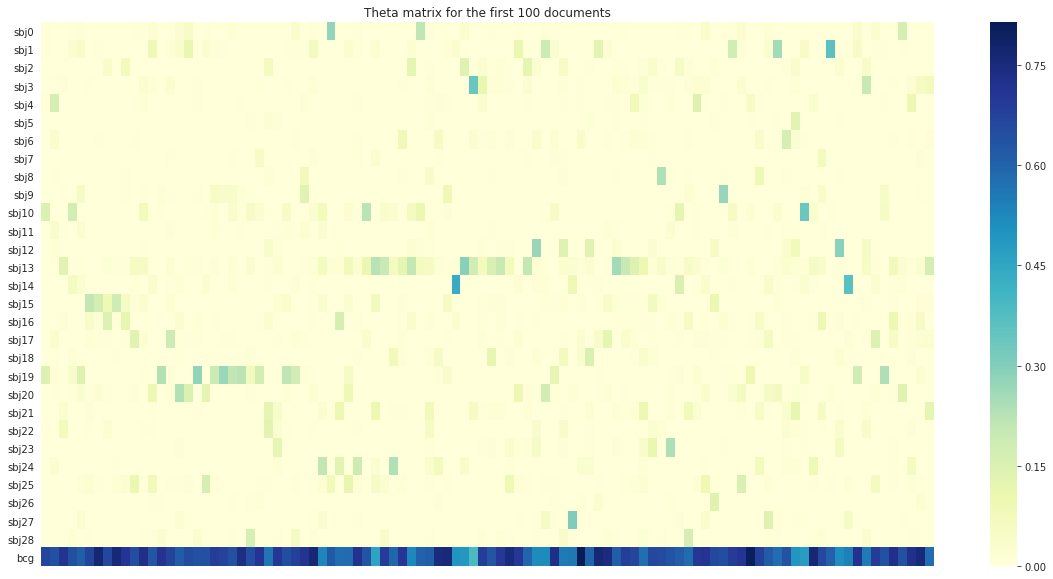

In [94]:
# Ваш код

import seaborn as sns
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(theta.iloc[:,:100], cmap='YlGnBu', xticklabels=False)
plt.show();

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [95]:
prob_theme_data = [np.sum(theta.iloc[i]) for i in range(theta.shape[0])]
prob_theme_data_normed = prob_theme_data / np.sum(prob_theme_data)
prob_theme = pd.DataFrame(data=prob_theme_data_normed, index=topic_labels, columns=['prob'])
prob_theme


,prob
Физика элементарных частиц,0.010324
Физика твердого тела,0.016254
История и политика,0.010535
Система образования и психология познания,0.007293
Мозг человека его устройство и развитие от ребенка к взрослому,0.007481
Мифология древних греков,0.007164
Русский язык,0.008591
Народы мира,0.005086
Право в римской империи,0.008632
Медицина,0.011317


In [96]:
prob_theme_max = prob_theme
prob_theme_min = prob_theme

print('Max 5 probabilities:')
for i in range(5):
    max_value = prob_theme_max.max()[0]
    print(prob_theme_max[prob_theme_max.values == max_value].index[0])
    prob_theme_max = prob_theme_max[prob_theme_max.values != max_value]

print('\nMin 3 probabilities:')
for i in range(3):
    min_value = prob_theme_min.min()[0]
    print(prob_theme_min[prob_theme_min.values == min_value].index[0])
    prob_theme_min = prob_theme_min[prob_theme_min.values != min_value]



Max 5 probabilities:
Фоновая тема
Социология
Генетика
Квантовая физика
История времен руси

Min 3 probabilities:
История CCCР
Народы мира
Психология восприятия


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

Ваш ответ:
5 тем с max p(t): Фоновая тема
Социология
Генетика
Квантовая физика
История времен руси
3 темы с min p(t): История CCCР
Народы мира
Психология восприятия

Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

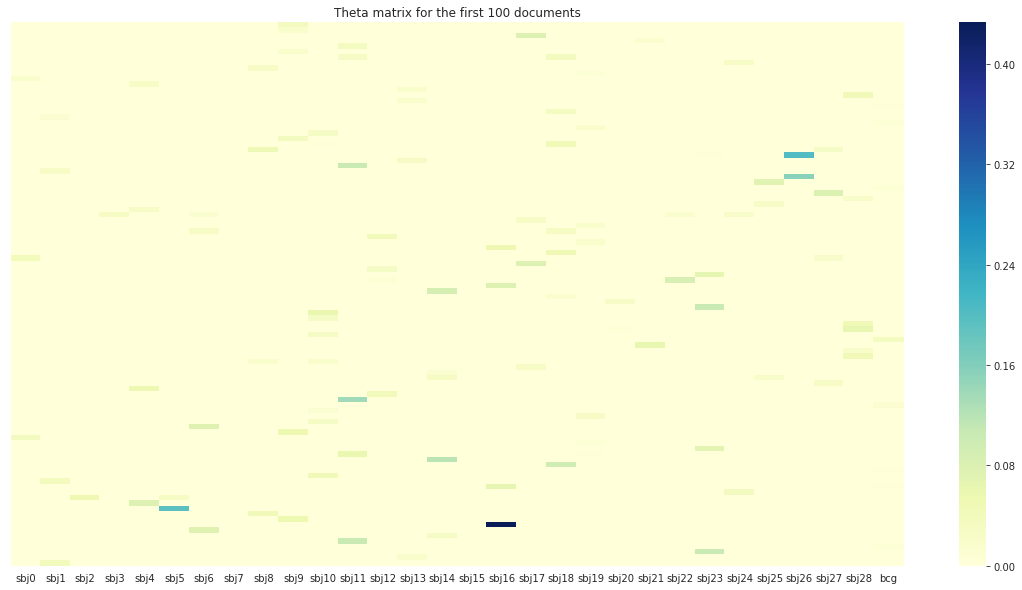

In [97]:
# Ваш код
plt.figure(figsize=(20,10))
plt.title('Theta matrix for the first 100 documents')
sns.heatmap(phi_a.iloc[:100], cmap='YlGnBu', yticklabels=False)
plt.show();


Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

Ваш ответ:
авторы, значимые в не менее чем 3 темах: 35 Илья_Иткин
105 Олег_Ауров
155 Ольга_Вайнштейн
288 Фёдор_Успенский
405 Александр_Пиперски
483 Андрей_Журавлев

In [100]:
for i in range(phi_a.shape[0]):
    num_valuble_topics = 0
    for val in phi_a.iloc[i]:
        if val > 0.01:
            num_valuble_topics += 1
    if num_valuble_topics >= 3:
        print(i ,phi_a.index[i][1])



35 Илья_Иткин
105 Олег_Ауров
155 Ольга_Вайнштейн
288 Фёдор_Успенский
405 Александр_Пиперски
483 Андрей_Журавлев


Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_t' p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [0]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [0]:
# Ваш код
prob_theme_author = np.empty(phi_a.shape)
for i in range(prob_theme_author.shape[0]):
    for j in range(prob_theme_author.shape[1]):
        prob_theme_author[i,j] = phi_a.iloc[i,j] * prob_theme.iloc[j,:] / np.sum(phi_a.iloc[i,:] * prob_theme.prob.values)


Визуализируйте найденные двумерные представления с помощью функции scatter. 

In [0]:
# Ваш код

similarities = pairwise_distances(prob_theme_author, metric='cosine')
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pos = mds.fit_transform(similarities)

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

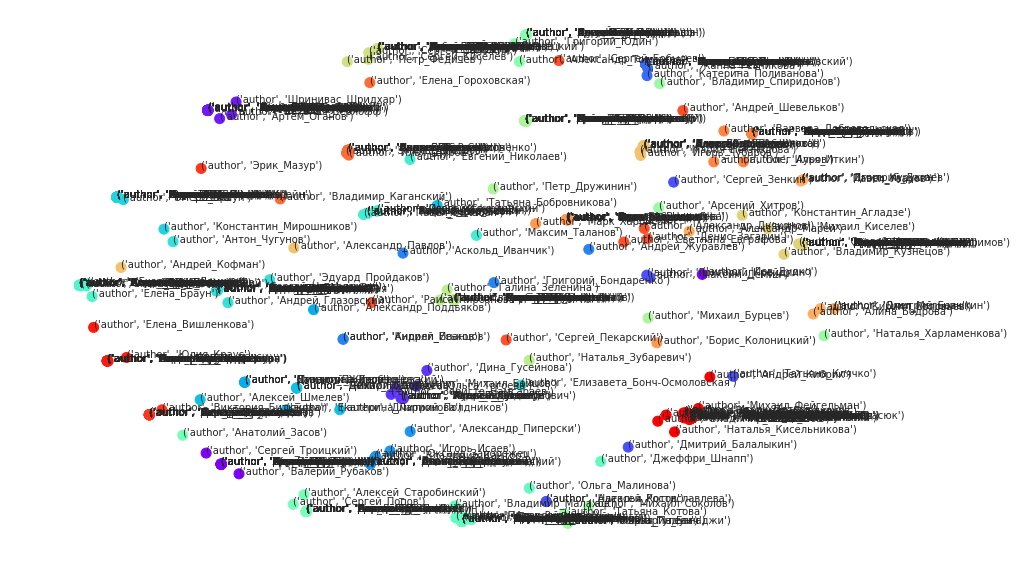

In [125]:
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T)) # цвета для тем
# Ваш код
max_theme_prob_for_colors = [np.argmax(author) for author in prob_theme_author]
plt.figure(figsize=(15,10))
plt.axis('off')
plt.scatter(pos[:,0], pos[:,1], s=100, c=colors[max_theme_prob_for_colors])
for i, author in enumerate(phi_a.index):
        plt.annotate(author, pos[i])
plt.savefig(os.path.join(DATA_PATH, 'authors_map.pdf'), dpi=200, format='pdf')
plt.show();


##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [108]:
prob_doc_theme = theta.values / np.array([np.sum(theme) for theme in theta.values])[:, np.newaxis]
prob_doc_theme_sorted_indices = prob_doc_theme.argsort(axis=1)[:,::-1]
prob_doc_theme_sorted_indices

array([[1326, 1593, 1594, ..., 1015, 1016,  374],
       [  88,  817,  649, ..., 1036, 1034, 1727],
       [1493,  593,  558, ..., 1041, 1042,    0],
       ...,
       [1447, 1041,   59, ..., 1008, 1009,  863],
       [1453, 1123, 1251, ..., 1032, 1036,    0],
       [ 539,  278,  746, ..., 1120, 1091, 1018]])

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [0]:
print "http://yandex.ru"   # получится кликабельная ссылка

Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [110]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [123]:
# Ваш код
tokens = model_artm.score_tracker['text_top_words'].last_tokens
for i, theme in enumerate(topic_labels):
    display(HTML("<h3>%s</h3>" % theme))
    
    s = ''
    for j in range(10):
        s += ' ' + tokens[model_artm.topic_names[i]][j]
    print(s)
    for k in range(10):
        print(theta.columns[prob_doc_theme_sorted_indices[i,k]])


 частица взаимодействие физика кварк симметрия элементарный стандартный нейтрино материя протон
http://postnauka.ru/video/13043
http://postnauka.ru/video/18870
http://postnauka.ru/video/18873
http://postnauka.ru/video/47950
http://postnauka.ru/video/2945
http://postnauka.ru/video/11634
http://postnauka.ru/video/47175
http://postnauka.ru/video/478
http://postnauka.ru/video/1894
http://postnauka.ru/video/14282


 материал температура структура вещество химический соединение свойство поверхность химия давление
http://postnauka.ru/video/31182
http://postnauka.ru/video/13700
http://postnauka.ru/video/57995
http://postnauka.ru/video/18048
http://postnauka.ru/video/41686
http://postnauka.ru/video/46379
http://postnauka.ru/video/50340
http://postnauka.ru/video/51490
http://postnauka.ru/video/13544
http://postnauka.ru/video/56295


 политический государство политика царь партия власть правитель враг кризис ритуал
http://postnauka.ru/video/5517
http://postnauka.ru/video/52941
http://postnauka.ru/video/5179
http://postnauka.ru/video/32906
http://postnauka.ru/video/13538
http://postnauka.ru/video/12083
http://postnauka.ru/video/32882
http://postnauka.ru/video/56304
http://postnauka.ru/video/59199
http://postnauka.ru/video/21318


 университет знание предмет школа восприятие образование познание факультет студент аргумент
http://postnauka.ru/video/2973
http://postnauka.ru/video/31198
http://postnauka.ru/video/19570
http://postnauka.ru/video/35038
http://postnauka.ru/video/55533
http://postnauka.ru/video/49445
http://postnauka.ru/video/40889
http://postnauka.ru/video/50406
http://postnauka.ru/video/55217
http://postnauka.ru/video/3603


 мозг ребенок мышление нейрон предложение категория взрослый чтение лицо синтаксический
http://postnauka.ru/video/7767
http://postnauka.ru/video/50793
http://postnauka.ru/video/55068
http://postnauka.ru/video/47548
http://postnauka.ru/video/12521
http://postnauka.ru/video/26207
http://postnauka.ru/video/5178
http://postnauka.ru/video/25891
http://postnauka.ru/video/36350
http://postnauka.ru/video/27965


 бог миф греческий герой море мифология грек древний персонаж мифологический
http://postnauka.ru/video/43664
http://postnauka.ru/video/5181
http://postnauka.ru/video/27831
http://postnauka.ru/video/42796
http://postnauka.ru/video/31990
http://postnauka.ru/video/21637
http://postnauka.ru/video/46427
http://postnauka.ru/video/36716
http://postnauka.ru/video/12527
http://postnauka.ru/video/47300


 русский текст город городской перевод корпус гласный москва документ говор
http://postnauka.ru/video/13156
http://postnauka.ru/video/51171
http://postnauka.ru/video/24279
http://postnauka.ru/video/8964
http://postnauka.ru/video/48112
http://postnauka.ru/video/24945
http://postnauka.ru/video/57318
http://postnauka.ru/video/47301
http://postnauka.ru/video/23470
http://postnauka.ru/video/10773


 трудность раса праздник тест америка шаман станислав задание нос сакральный
http://postnauka.ru/video/31707
http://postnauka.ru/video/37732
http://postnauka.ru/video/32898
http://postnauka.ru/video/35150
http://postnauka.ru/video/42707
http://postnauka.ru/video/15341
http://postnauka.ru/video/42735
http://postnauka.ru/video/31675
http://postnauka.ru/video/17397
http://postnauka.ru/video/40880


 право римский правовой юрист суд юридический сон должник собственность закон
http://postnauka.ru/video/9299
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/49455
http://postnauka.ru/video/42221
http://postnauka.ru/video/17912
http://postnauka.ru/video/16822
http://postnauka.ru/video/31666
http://postnauka.ru/video/17875
http://postnauka.ru/video/31688


 болезнь заболевание пациент лечение медицина врач боль препарат медицинский иммунный
http://postnauka.ru/video/13746
http://postnauka.ru/video/532
http://postnauka.ru/video/7753
http://postnauka.ru/video/2541
http://postnauka.ru/video/11361
http://postnauka.ru/video/12974
http://postnauka.ru/video/49206
http://postnauka.ru/video/11850
http://postnauka.ru/video/45961
http://postnauka.ru/video/51384


 животное организм робот вода растение микроорганизм биологический нервный рецептор эволюция
http://postnauka.ru/video/9861
http://postnauka.ru/video/30673
http://postnauka.ru/video/8953
http://postnauka.ru/video/2531
http://postnauka.ru/video/32635
http://postnauka.ru/video/7113
http://postnauka.ru/video/19071
http://postnauka.ru/video/25889
http://postnauka.ru/video/49437
http://postnauka.ru/video/11061


 память информация когнитивный зрительный психолог запоминать храниться воспроизводить мария картинка
http://postnauka.ru/video/9997
http://postnauka.ru/video/56052
http://postnauka.ru/video/54916
http://postnauka.ru/video/57336
http://postnauka.ru/video/37979
http://postnauka.ru/video/27845
http://postnauka.ru/video/38507
http://postnauka.ru/video/3645
http://postnauka.ru/video/17421
http://postnauka.ru/video/23079


 империя германия историк государственный церковь исторический война русь военный святой
http://postnauka.ru/video/24034
http://postnauka.ru/video/3348
http://postnauka.ru/video/24039
http://postnauka.ru/video/32637
http://postnauka.ru/video/19574
http://postnauka.ru/video/35041
http://postnauka.ru/video/23900
http://postnauka.ru/video/50668
http://postnauka.ru/video/31183
http://postnauka.ru/video/50350


 наука социальный рассказывать общество понятие кандидат история исторический культурный каков
http://postnauka.ru/video/10749
http://postnauka.ru/video/9148
http://postnauka.ru/video/10783
http://postnauka.ru/video/7778
http://postnauka.ru/video/9870
http://postnauka.ru/video/17491
http://postnauka.ru/video/5878
http://postnauka.ru/video/3417
http://postnauka.ru/video/6380
http://postnauka.ru/video/11644


 галактика планета земля звезда черный масса дыра газ атмосфера диск
http://postnauka.ru/video/2971
http://postnauka.ru/video/9835
http://postnauka.ru/video/31193
http://postnauka.ru/video/57338
http://postnauka.ru/video/31695
http://postnauka.ru/video/36249
http://postnauka.ru/video/3604
http://postnauka.ru/video/3423
http://postnauka.ru/video/58744
http://postnauka.ru/video/45644


 решение экономический экономика деньги компания выбор ценность принятие международный ресурс
http://postnauka.ru/video/53415
http://postnauka.ru/video/5465
http://postnauka.ru/video/13152
http://postnauka.ru/video/24286
http://postnauka.ru/video/51488
http://postnauka.ru/video/28278
http://postnauka.ru/video/26119
http://postnauka.ru/video/14280
http://postnauka.ru/video/7781
http://postnauka.ru/video/43679


 человек поведение психология женщина психологический конфликт эмоция мужчина коллективный способность
http://postnauka.ru/video/22892
http://postnauka.ru/video/21643
http://postnauka.ru/video/22883
http://postnauka.ru/video/26223
http://postnauka.ru/video/40866
http://postnauka.ru/video/9865
http://postnauka.ru/video/9729
http://postnauka.ru/video/21661
http://postnauka.ru/video/16191
http://postnauka.ru/video/2946


 задача данные компьютер сеть программа компьютерный ошибка интернет обучение искусственный
http://postnauka.ru/video/32901
http://postnauka.ru/video/24306
http://postnauka.ru/video/8313
http://postnauka.ru/video/33885
http://postnauka.ru/video/55303
http://postnauka.ru/video/47810
http://postnauka.ru/video/12172
http://postnauka.ru/video/28557
http://postnauka.ru/video/13155
http://postnauka.ru/video/9998


 территория словарь восток письменность народ северный китай древний памятник восточный
http://postnauka.ru/video/53171
http://postnauka.ru/video/5891
http://postnauka.ru/video/59201
http://postnauka.ru/video/2527
http://postnauka.ru/video/17041
http://postnauka.ru/video/12515
http://postnauka.ru/video/51380
http://postnauka.ru/video/25290
http://postnauka.ru/video/56302
http://postnauka.ru/video/52958


 клетка ген днк белок организм молекула генетический молекулярный геном бактерия
http://postnauka.ru/video/5390
http://postnauka.ru/video/10475
http://postnauka.ru/video/17051
http://postnauka.ru/video/27434
http://postnauka.ru/video/35461
http://postnauka.ru/video/35051
http://postnauka.ru/video/32881
http://postnauka.ru/video/5915
http://postnauka.ru/video/16156
http://postnauka.ru/video/37537


 энергия поле квантовый магнитный свет волна электрон атом эффект фотон
http://postnauka.ru/video/19457
http://postnauka.ru/video/24434
http://postnauka.ru/video/25875
http://postnauka.ru/video/21662
http://postnauka.ru/video/51174
http://postnauka.ru/video/19509
http://postnauka.ru/video/3381
http://postnauka.ru/video/23335
http://postnauka.ru/video/26609
http://postnauka.ru/video/18221


 культура философия философский философ автор произведение идеология религиозный литература платон
http://postnauka.ru/video/2529
http://postnauka.ru/video/12738
http://postnauka.ru/video/7764
http://postnauka.ru/video/9728
http://postnauka.ru/video/53513
http://postnauka.ru/video/23834
http://postnauka.ru/video/32664
http://postnauka.ru/video/7068
http://postnauka.ru/video/46317
http://postnauka.ru/video/37965


 революция власть король французский реформа петр против франция народ сталин
http://postnauka.ru/video/53577
http://postnauka.ru/video/48492
http://postnauka.ru/video/54175
http://postnauka.ru/video/47823
http://postnauka.ru/video/1893
http://postnauka.ru/video/58542
http://postnauka.ru/video/25882
http://postnauka.ru/video/42993
http://postnauka.ru/video/42996
http://postnauka.ru/video/50656


 советский россия война мировой союз гражданский песня екатерина обряд армия
http://postnauka.ru/video/34413
http://postnauka.ru/video/30261
http://postnauka.ru/video/46939
http://postnauka.ru/video/52936
http://postnauka.ru/video/57259
http://postnauka.ru/video/25890
http://postnauka.ru/video/41680
http://postnauka.ru/video/55219
http://postnauka.ru/video/47816
http://postnauka.ru/video/25906


 язык христианский литературный филологический христианство лингвист глагол лингвистика языковой христианин
http://postnauka.ru/video/7755
http://postnauka.ru/video/13041
http://postnauka.ru/video/10473
http://postnauka.ru/video/55301
http://postnauka.ru/video/52778
http://postnauka.ru/video/3387
http://postnauka.ru/video/53169
http://postnauka.ru/video/49203
http://postnauka.ru/video/16157
http://postnauka.ru/video/14297


 теория пространство описывать математический теоретический матрица уравнение математика описание линейный
http://postnauka.ru/video/3388
http://postnauka.ru/video/36804
http://postnauka.ru/video/57128
http://postnauka.ru/video/55069
http://postnauka.ru/video/18085
http://postnauka.ru/video/19456
http://postnauka.ru/video/18086
http://postnauka.ru/video/34416
http://postnauka.ru/video/51371
http://postnauka.ru/video/25278


 внимание костюм коллективизация скелет сочетание фразеологизм финансовый воображение порнография термоэлектрический
http://postnauka.ru/video/9389
http://postnauka.ru/video/31684
http://postnauka.ru/video/43843
http://postnauka.ru/video/49866
http://postnauka.ru/video/40004
http://postnauka.ru/video/37978
http://postnauka.ru/video/36242
http://postnauka.ru/video/57127
http://postnauka.ru/video/30601
http://postnauka.ru/video/26616


 звезда объект вселенная излучение белый нейтронный измерять карлик спектр вещество
http://postnauka.ru/video/53693
http://postnauka.ru/video/6673
http://postnauka.ru/video/30015
http://postnauka.ru/video/59202
http://postnauka.ru/video/23969
http://postnauka.ru/video/49447
http://postnauka.ru/video/10756
http://postnauka.ru/video/12372
http://postnauka.ru/video/38007
http://postnauka.ru/video/23500


 фильм свобода роль кино кинематограф культовый академия академический профессор отделение
http://postnauka.ru/video/5396
http://postnauka.ru/video/9429
http://postnauka.ru/video/10779
http://postnauka.ru/video/39723
http://postnauka.ru/video/11246
http://postnauka.ru/video/8623
http://postnauka.ru/video/7074
http://postnauka.ru/video/57126
http://postnauka.ru/video/19436
http://postnauka.ru/video/45548


 быть что это который этот как они мочь такой очень
http://postnauka.ru/video/51365
http://postnauka.ru/video/49851
http://postnauka.ru/video/42436
http://postnauka.ru/video/54112
http://postnauka.ru/video/58752
http://postnauka.ru/video/49441
http://postnauka.ru/video/41678
http://postnauka.ru/video/36857
http://postnauka.ru/video/9037
http://postnauka.ru/video/5602


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 